In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls

gdrive	output.csv  output.json  sample_data


In [ ]:
!pip list --format=freeze > requirements.txt

In [ ]:
# Import yolo library
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms, models
from transformers import CLIPProcessor, CLIPModel, Blip2Processor, Blip2Model
import json

from torch.utils.data import DataLoader, Dataset
import os

In [ ]:
pwd

'/content'

In [ ]:
PATH_MODEL_YOLO = '/content/gdrive/MyDrive/Llava/HCMC_HACK/runs/detect/train/weights/best.pt'
PATH_MODEL_MOBILENET = '/content/gdrive/MyDrive/Llava/MobileNet/mobilenet_v3_beer.pth'

In [ ]:
# Initialize YOLOv9
model_YOLO = YOLO(PATH_MODEL_YOLO)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize CLIP
processor_CLIP = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model_CLIP = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model_CLIP.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
PATH_IMAGE = '/content/gdrive/MyDrive/Llava/HackHCMC/FULL [Heineken Vietnam] Developer Resources/429684007_1655270175212015_6555900008351011215_n.jpg'

In [ ]:
# detect Emotion
def infer_image_emotion(image, processor, model):
    list_labels = ["A person is happy",
                    "A person is Angry",
                    "A person is Enjoyable",
                    "A person is Relaxed",
                    "A person is Neutral",
                    "Cannot idenitify the emotion"]
    image = Image.fromarray(image)

    inputs = processor(
        text = list_labels,
        images = image,
        return_tensors = "pt",
        padding=True
    )

    model.to(device)

    pixel_values = inputs["pixel_values"].to(device)
    labels = inputs["input_ids"].to(device)

    output = model(pixel_values = pixel_values, input_ids = labels)

    logits_per_image = output['logits_per_image']
    logits_per_text = output['logits_per_text']

    pred = torch.argmax(logits_per_image)
    final_result = list_labels[pred]

    return final_result

# list_scene_label = ["The bar scene", "The pub scene", "The restaurant scene",
#                     "The grocery store scene", "The supermarket scene",
#                     "The party scene", "The celebration scene",
#                     "The gathering scene"]
list_labels_Scene = ["The bar scene", "The pub scene", "The restaurant scene",
                    "The grocery store scene", "The supermarket scene",
                    "The party scene", "The celebration scene",
                    "The gathering scene"]

list_labels_Environment = ["Outside", "Inside"]

def infer_image_context(image, list_labels, processor,
                   model, device = "cuda", number_images = 20, display = True):


    image = Image.fromarray(image)

    inputs = processor(
        text = list_labels,
        images = image,
        return_tensors = "pt",
        padding = True
    )

    model.to(device)

    pixel_values = inputs["pixel_values"].to(device)
    labels = inputs["input_ids"].to(device)

    output = model(pixel_values = pixel_values, input_ids = labels)

    logits_per_image = output['logits_per_image']
    logits_per_text = output['logits_per_text']

    pred = torch.argmax(logits_per_image)
    final_result = list_labels[pred]

    return final_result

In [ ]:
# results = model_YOLO.predict(PATH_IMAGE)
# draw_bouding_box(img_array, results)

# plt.imshow(img_array)
# plt.show()

In [ ]:
def crop_person(image, results):
    # crop beers
    persons = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get the bounding box coordinates
            if int(box.cls[0]) == 35:
                x1, y1, x2, y2 = box.xyxy[0]

                # Crop the image
                cropped_image = image[int(y1):int(y2), int(x1):int(x2), :]
                persons.append(cropped_image)
    return persons

def crop_beer(image, results):
    # crop beers
    beers = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get the bounding box coordinates
            if int(box.cls[0])%5 == 0 and int(box.cls[0]) != 35:
                x1, y1, x2, y2 = box.xyxy[0]

                # Crop the image
                cropped_image = image[int(y1):int(y2), int(x1):int(x2), :]
                cropped_image = cv2.resize(cropped_image, (224, 224))
                beers.append(cropped_image)

In [ ]:
# persons = crop_person(img_array, results)

# for person in persons:
#     result = infer_image_emotion(person, processor_CLIP, model_CLIP)
#     fig, ax = plt.subplots()
#     ax.imshow(person)
#     ax.set_title(result)
#     plt.show()

In [ ]:
def draw_bouding_box(img_array, results):
    # draw bouding box
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get the bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # Get the class label and confidence score
            class_id = int(box.cls[0])
            class_name = model_YOLO.names[class_id]
            confidence = float(box.conf[0])

            # Draw the bounding box and label on the frame
            cv2.rectangle(img_array, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_array, f'{class_name} ({confidence:.2f})', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)

In [ ]:
def frequency_class(results):
    # count frequency class
    frequency = {}
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get the class label and confidence score
            class_id = int(box.cls[0])
            class_name = model_YOLO.names[class_id]
            if class_name in frequency:
                frequency[class_name] += 1
            else:
                frequency[class_name] = 1
    return frequency


In [ ]:
def extract_json(data):
    with open("output.json", "w") as file:
        json.dump(data, file, indent=len(data))

In [ ]:
def detect_all(image_path, idx):
    # Open the image file with Pillow
    # img = Image.open(PATH_IMAGE)  # Replace with your image path
    img = cv2.imread(image_path)
    # Convert the image to RGB format (Matplotlib expects RGB images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image data to a NumPy array (because Matplotlib needs this as input)
    img_array = np.array(img)

    # Use Matplotlib to display the image
    plt.imshow(img_array)
    plt.show()

    objects = []

    results = model_YOLO.predict(image_path)

    persons = crop_person(img_array, results)
    print(len(persons))

    for person in persons:
        result = infer_image_emotion(person, processor_CLIP, model_CLIP)
        fig, ax = plt.subplots()
        ax.imshow(person)
        ax.set_title(result)
        plt.show()

    # img = img_array.copy()

    draw_bouding_box(img, results)
    plt.imshow(img)

    freq = frequency_class(results)

    context = infer_image_context(img_array, list_labels_Scene, processor_CLIP, model_CLIP)
    # print(context)

    env = infer_image_context(img_array, list_labels_Environment, processor_CLIP, model_CLIP)
    # print(env)

    class_names = model_YOLO.names
    # print(class_names)

    object_image = {'image_id': idx, "objects": freq, "context": context,
                    "environment": env }

    objects.append(object_image)
    return objects

# object_lol = detect_all(PATH_IMAGE, 1)

# print(object_lol)

In [ ]:
def dectection(path_dir):
    objects = []
    for idx, filename in enumerate(os.listdir(path_dir)):
        obj = detect_all(os.path.join(path_dir, filename), idx)[0]
        objects.append(obj)
    return objects


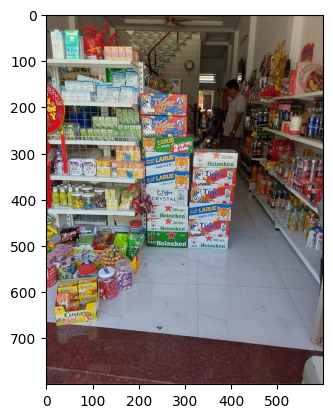


image 1/1 /content/gdrive/MyDrive/Llava/ImageOnlyLOL/66502587_1706532187339.jpg: 640x480 5 heineken_beers, 4 larue_beers, 6 tiger_beers, 28.8ms
Speed: 3.5ms preprocess, 28.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


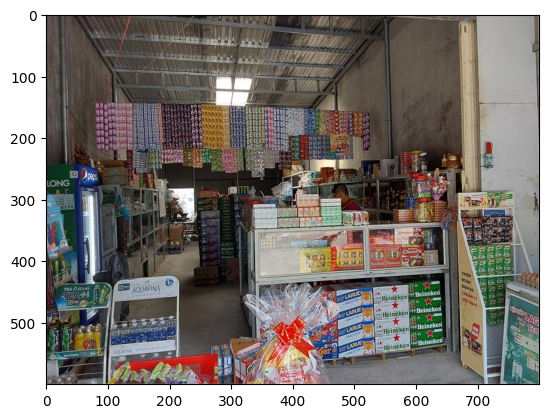


image 1/1 /content/gdrive/MyDrive/Llava/ImageOnlyLOL/66502444_1706022211861.jpg: 480x640 2 heineken_beers, 2 larue_beers, 1 tiger_beer, 26.2ms
Speed: 4.2ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


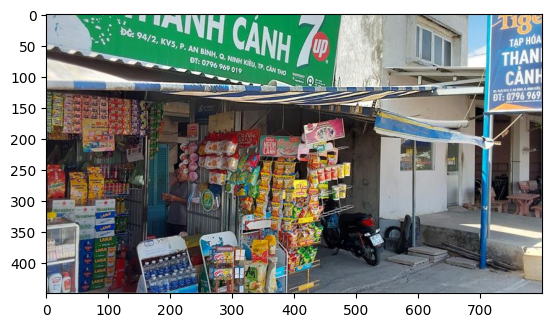


image 1/1 /content/gdrive/MyDrive/Llava/ImageOnlyLOL/66502597_1708612035063.jpg: 384x640 5 heineken_beers, 7 larue_beers, 4 tiger_beers, 1 tiger_billboard, 25.7ms
Speed: 2.8ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


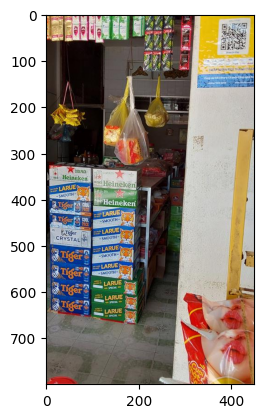


image 1/1 /content/gdrive/MyDrive/Llava/ImageOnlyLOL/66502830_1708611438644.jpg: 640x384 2 heineken_beers, 3 larue_beers, 3 tiger_beers, 33.0ms
Speed: 3.1ms preprocess, 33.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


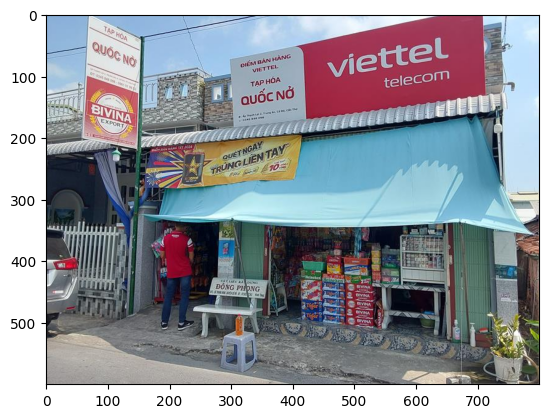


image 1/1 /content/gdrive/MyDrive/Llava/ImageOnlyLOL/66502810_1706186045393.jpg: 480x640 1 bivina_beer, 1 bivina_billboard, 2 heineken_beers, 2 larue_beers, 3 tiger_beers, 25.9ms
Speed: 3.2ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
obj = dectection('/content/gdrive/MyDrive/Llava/ImageOnlyLOL')
extract_json(obj)

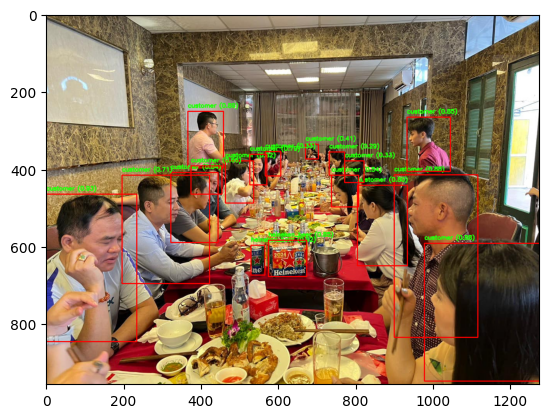